# Project: Inventory Monitoring at Distribution Centers

- The traditional method of inventory management, which relies heavily on manual labor, is not only labor-intensive but also prone to errors. This necessitates a more efficient approach to inventory management that can save time, boost productivity, and minimize errors. The advent of technology, specifically automation, can address these issues, leading to cost and time savings. 

- For larger organizations, the process becomes more complex, and this is where machine-assisted tasks come into play. Leveraging computer vision techniques can help solve the problem at hand. With the escalating demand for inventory management, scalability becomes a paramount concern that can impact the long-term sustainability of the business. An automated workflow simplifies scalability, making it more cost-effective. 

- The proposed solution is versatile and can be applied to various objects, given the respective datasets for training. The results are quantifiable, according to the proposed evaluation metrics. We have framed the problem as a classification task, where an input image from a live camera is used to predict the count of objects in a bin using a machine learning model. This notebook provides a step-by-step walkthrough of this solution.


In [3]:
%%capture
!pip install torch torchvision

In [4]:
# TODO: Import any packages that you might need
import argparse
import numpy as np
import json
import logging
import os
import io
import sys
import matplotlib.pyplot as plt
import requests
from PIL import Image
import json

import boto3
import torch
import sagemaker
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils import data
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

## Data Preparation

- The subsequent code cell accomplishes several tasks. It first establishes a directory named 'train_data', then proceeds to download the training data and organizes it into distinct subdirectories. Each of these subdirectories is designated by the count of objects they contain. For instance, the subdirectory titled '1' houses images that depict a single object.

- This organization does not segment images into training, testing, or validation sets. Should you find the quantity of samples inadequate, you have the option to download additional data (guidelines for this can be found here). It's important to note that the focus here is not the accuracy of your ultimate trained model, but rather the construction of your machine learning engineering pipeline. (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)).

In [8]:
import os
import json
import boto3
from tqdm import tqdm
import concurrent.futures

train_data_path = "./train_data"
s3_client = boto3.client('s3')

if not os.path.exists(train_data_path):
    print("Created %s. " % train_data_path)
    os.mkdir(train_data_path)

def download_file(directory, file_path):
    """Download a file from s3 to local."""
    file_name = os.path.basename(file_path).split('.')[0]+'.jpg'
    s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                     os.path.join(directory, file_name))
    
def download_and_arrange_data():
    """Download and arrange data from s3."""
    with open('file_list.json', 'r') as f:
        d = json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory = os.path.join(train_data_path, k)
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        file_path_list = v
        
        # Use a ThreadPoolExecutor to download files in parallel
        with concurrent.futures.ThreadPoolExecutor() as executor:
            list(tqdm(executor.map(download_file, [directory]*len(file_path_list), file_path_list), total=len(file_path_list)))

download_and_arrange_data()

100%|██████████| 1228/1228 [00:16<00:00, 75.15it/s]

  0%|          | 0/2299 [00:00<?, ?it/s]


100%|██████████| 2299/2299 [00:29<00:00, 77.84it/s]



100%|██████████| 2666/2666 [00:33<00:00, 78.45it/s]

  0%|          | 0/2373 [00:00<?, ?it/s]


100%|██████████| 2373/2373 [00:32<00:00, 72.96it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]


100%|██████████| 1875/1875 [00:23<00:00, 79.15it/s]


## Dataset

- The model will be trained using the Amazon Bin Image Dataset. This dataset comprises over half a million images, along with corresponding metadata, sourced from bins within an active Amazon Fulfillment Center. The bin images were captured while robotic units transported pods as a routine part of the Fulfillment Center's operations. More information about this open-source dataset can be found in its official documentation, accessible via this link.[here](https://registry.opendata.aws/amazon-bin-imagery/).

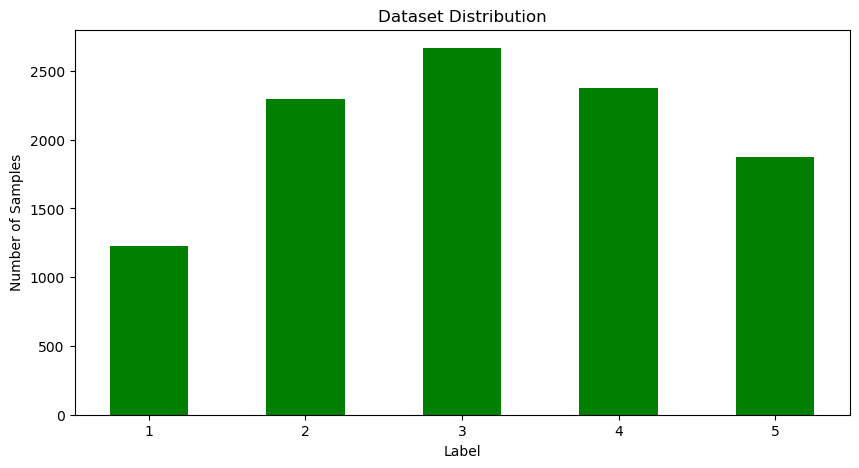

In [10]:
#TODO: Perform any data cleaning or data preprocessing
import numpy as np
import matplotlib.pyplot as plt


# creating the dataset
data = {'1':1228, '2':2299, '3':2666, '4':2373, '5':1875}
object_count = list(data.keys())
n_samples = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(object_count, n_samples, color ='green', width = 0.5)

plt.xlabel("Label")
plt.ylabel("Number of Samples")
plt.title("Dataset Distribution")
plt.show()

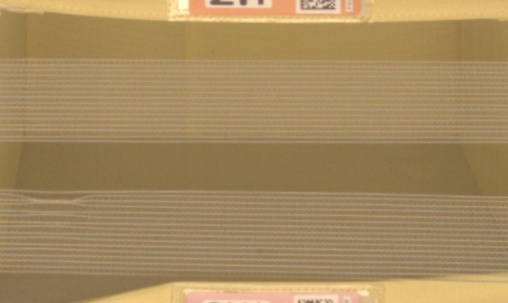

In [11]:
request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/123.jpg" }
img_bytes = requests.get(request_dict['url']).content
Image.open(io.BytesIO(img_bytes))

In [12]:
os.environ['SM_CHANNEL_TRAINING']='s3://bucket-381195239495/'
os.environ['SM_MODEL_DIR']='s3://bucket-381195239495/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://bucket-381195239495/output/'

In [14]:
%%capture
!aws s3 cp train_data s3://bucket-381195239495/train_data/ --recursive

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [15]:
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()

In [16]:
# Declare model training hyperparameter.
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128]),
    "epochs": CategoricalParameter([10,15, 25 , 30 ])
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [17]:
# Create  training estimator
estimator = PyTorch(
    entry_point="tuner.py",
    base_job_name='pytorch_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    py_version='py3'
)

In [18]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type
)

In [19]:
tuner.fit({"training": "s3://bucket-381195239495/train_data/"})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.............................................................................................................................................................................................................................................................................................................!


## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [20]:
tuner.describe()

{'HyperParameterTuningJobName': 'pytorch-training-230517-1444',
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:381195239495:hyper-parameter-tuning-job/pytorch-training-230517-1444',
 'HyperParameterTuningJobConfig': {'Strategy': 'Bayesian',
  'HyperParameterTuningJobObjective': {'Type': 'Minimize',
   'MetricName': 'Test Loss'},
  'ResourceLimits': {'MaxNumberOfTrainingJobs': 2,
   'MaxParallelTrainingJobs': 2},
  'ParameterRanges': {'IntegerParameterRanges': [],
   'ContinuousParameterRanges': [{'Name': 'learning_rate',
     'MinValue': '0.001',
     'MaxValue': '0.1',
     'ScalingType': 'Auto'}],
   'CategoricalParameterRanges': [{'Name': 'batch_size',
     'Values': ['"32"', '"64"', '"128"']},
    {'Name': 'epochs', 'Values': ['"10"', '"15"', '"25"', '"30"']}]},
  'TrainingJobEarlyStoppingType': 'Off'},
 'TrainingJobDefinition': {'StaticHyperParameters': {'_tuning_objective_metric': 'Test Loss',
   'sagemaker_container_log_level': '20',
   'sagemaker_estimator_class_na

In [21]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics

exp = HyperparameterTuningJobAnalytics(hyperparameter_tuning_job_name=tuner.describe()['HyperParameterTuningJobName'])

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch_size,epochs,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,"""64""","""25""",0.060255,pytorch-training-230517-1444-001-8a8778cc,Completed,50.0,2023-05-17 14:47:42+00:00,2023-05-17 15:08:03+00:00,1221.0
0,"""128""","""10""",0.005471,pytorch-training-230517-1444-002-754a9c40,Completed,47.0,2023-05-17 14:47:04+00:00,2023-05-17 15:07:20+00:00,1216.0


In [24]:
training_job_name = str(tuner.describe()['HyperParameterTuningJobName'])
print(training_job_name)

pytorch-training-230517-1444


In [26]:
# get best estimator that has FinalObjectiveValue equal to 47.0
best_estimator = sagemaker.estimator.Estimator.attach("pytorch-training-230517-1444-002-754a9c40")
print(best_estimator.hyperparameters())


2023-05-17 15:07:22 Starting - Preparing the instances for training
2023-05-17 15:07:22 Downloading - Downloading input data
2023-05-17 15:07:22 Training - Training image download completed. Training in progress.
2023-05-17 15:07:22 Uploading - Uploading generated training model
2023-05-17 15:07:22 Completed - Resource retained for reuse
{'_tuning_objective_metric': 'Test Loss', 'batch_size': '"128"', 'epochs': '"10"', 'learning_rate': '0.005470847645526047', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"pytorch_hpo-2023-05-17-14-44-52-316"', 'sagemaker_program': '"tuner.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-381195239495/pytorch_hpo-2023-05-17-14-44-52-316/source/sourcedir.tar.gz"'}


In [27]:
hyperparameters = {
    "batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')),
    "learning_rate": float(best_estimator.hyperparameters()['learning_rate'].replace('"', '')),
    "epochs" : int(best_estimator.hyperparameters()['epochs'].replace('"', ''))
}

hyperparameters

{'batch_size': 128, 'learning_rate': 0.005470847645526047, 'epochs': 10}

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [28]:
# Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(base_config=rule_configs.loss_not_decreasing(),
                             rule_parameters={"tensor_regex": "CrossEntropyLoss_output_0",
                                             "mode": "TRAIN"}),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "10",
        "eval.save_interval": "1",
    }
)


profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=5)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [29]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_config_list = [
    CollectionConfig(
        name="CrossEntropyLoss_output_0",
        parameters={
            "include_regex": "CrossEntropyLoss_output_0", 
            "train.save_interval": "10",
            "eval.save_interval": "1"
        }
    )
]


hook_config = DebuggerHookConfig(
    collection_configs=collection_config_list
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [30]:
# Create and fit an estimator
estimator = PyTorch(
    entry_point='train.py',
    base_job_name='Training-job',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [31]:
estimator.fit({"training": "s3://bucket-381195239495/train_data/"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: Training-job-2023-05-17-15-14-23-663


2023-05-17 15:14:26 Starting - Starting the training job...
2023-05-17 15:14:56 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-05-17 15:16:03 Downloading - Downloading input data...
2023-05-17 15:16:24 Training - Downloading the training image...
2023-05-17 15:17:04 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-05-17 15:16:50,902 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-05-17 15:16:50,905 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-05-17 15:16:50,917 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-05-17 15:16:50,919 sagemaker_pytorch_co

In [34]:
%%capture
!pip install smdebug

In [35]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

trial.tensor_names()

[2023-05-17 16:32:31.081 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-05-17 16:32:31.130 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-381195239495/Training-job-2023-05-17-15-14-23-663/debug-output
[2023-05-17 16:32:31.881 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 214 more expected)', IncompleteRead(0 bytes read, 214 more expected)) while reading s3://sagemaker-us-east-1-381195239495/Training-job-2023-05-17-15-14-23-663/debug-output/index/000000000/000000000000_worker_0.json . Will retry now
[2023-05-17 16:32:35.277 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:198] Training has ended, will refresh one final time in 

['CrossEntropyLoss_output_0',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.relu_input_2',
 'layer3.4.relu_input_0',
 'layer3.4.relu_input_1',
 'layer3.4.relu_input_2',
 'layer3.5.relu_input_0',
 'layer3

In [42]:
import matplotlib.pyplot as plt
from smdebug.trials import create_trial
from smdebug import modes
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def get_data(trial, tensor_name, mode):
    tensor = trial.tensor(tensor_name)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("Train Data Loaded")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("Eval Data Loaded")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps - TRAIN")
    par.set_xlabel("Steps - EVAL")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Generated TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Generated EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.savefig('train_and_validation_loss.png')

    plt.show()

In [37]:
steps_eval, vals_eval = get_data(trial, tensor_name="CrossEntropyLoss_output_0", mode=ModeKeys.EVAL)
steps_train, vals_train = get_data(trial, tensor_name="CrossEntropyLoss_output_0", mode=ModeKeys.TRAIN)


# Get the tensors from S3
s3_output_path = estimator.latest_job_debugger_artifacts_path()

# Create a Trial https://github.com/awslabs/sagemaker-debugger/blob/master/docs/analysis.md#Trial
trial = create_trial(s3_output_path)

# Get all the tensor names
trial.tensor_names()

[2023-05-17 16:33:03.741 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-381195239495/Training-job-2023-05-17-15-14-23-663/debug-output
[2023-05-17 16:33:03.972 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 214 more expected)', IncompleteRead(0 bytes read, 214 more expected)) while reading s3://sagemaker-us-east-1-381195239495/Training-job-2023-05-17-15-14-23-663/debug-output/index/000000000/000000000120_worker_0.json . Will retry now
[2023-05-17 16:33:06.642 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-05-17 16:33:07.663 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.relu_input_2',
 'layer3.4.relu_input_0',
 'layer3.4.relu_input_1',
 'layer3.4.relu_input_2',
 'layer3.5.relu_input_0',
 'layer3

In [38]:
# Get the values of the tensor `val_acc`for mode GLOBAL (validation accuracy)
values = trial.tensor("CrossEntropyLoss_output_0").values(modes.GLOBAL)

# Convert it to numpy array
values_eval = np.array(list(values.items()))

fig = plt.figure(figsize=(12, 10))
plt.plot(values_eval[:, 1])
fig.suptitle('Validation Loss', fontsize=16)
plt.xlabel('Intervals of sampling', fontsize=16)
plt.ylabel('Loss', fontsize=16)
fig.savefig('validation_loss.png')

Train Data Loaded
Eval Data Loaded
Generated TRAIN plot
Generated EVAL plot


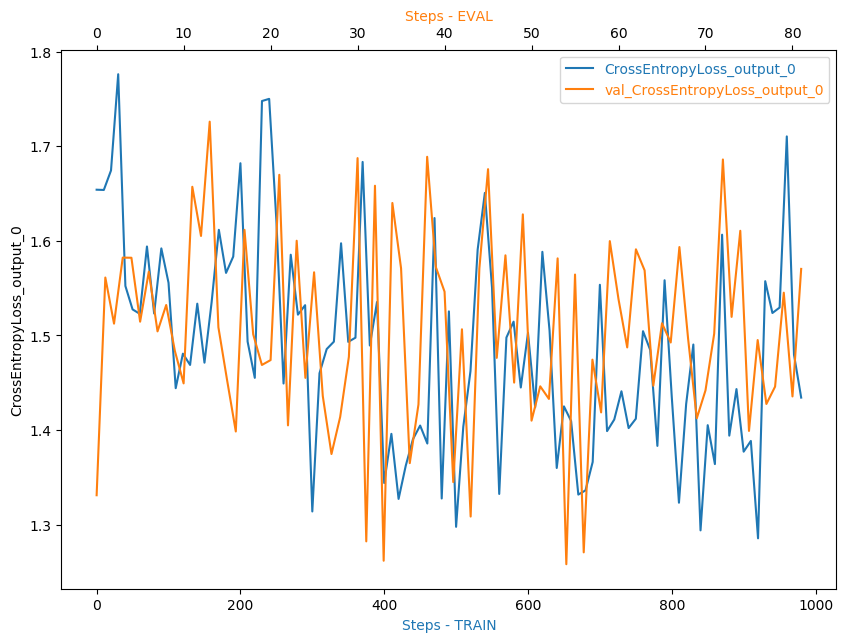

In [43]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [44]:
# Display the profiler output
import os

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-381195239495/Training-job-2023-05-17-15-14-23-663/rule-output


In [45]:
# get list of rule output and copy to local
!aws s3 ls {rule_output_path} --recursive
!aws s3 cp {rule_output_path} ./ --recursive

2023-05-17 16:19:08     329715 Training-job-2023-05-17-15-14-23-663/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-05-17 16:19:08     171077 Training-job-2023-05-17-15-14-23-663/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-05-17 16:19:04        192 Training-job-2023-05-17-15-14-23-663/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-05-17 16:19:04        200 Training-job-2023-05-17-15-14-23-663/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-05-17 16:19:04        126 Training-job-2023-05-17-15-14-23-663/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-05-17 16:19:04        127 Training-job-2023-05-17-15-14-23-663/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-05-17 16:19:04        199 Training-job-2023-05-17-15-14-23-663/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
2023

In [46]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [47]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Model Deploying and Querying

In [56]:
model_location = estimator.model_data
print(model_location)

s3://sagemaker-us-east-1-381195239495/Training-job-2023-05-17-15-14-23-663/output/model.tar.gz


In [57]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [58]:
pytorch_model = PyTorchModel(
    model_data=model_location, 
    role=role, 
    entry_point='inference.py',
    py_version='py3',                     
    framework_version='1.4',
    predictor_cls=ImagePredictor
)

In [59]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

INFO:sagemaker:Creating model with name: pytorch-inference-2023-05-17-16-51-43-692
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-05-17-16-51-44-796
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-05-17-16-51-44-796


----!

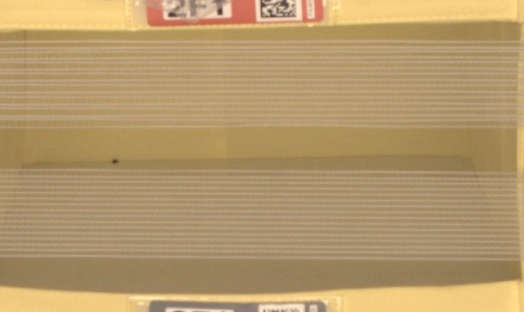

In [60]:
request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/111.jpg" }
img_bytes = requests.get(request_dict['url']).content
Image.open(io.BytesIO(img_bytes))

In [61]:
response = predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [62]:
np.argmax(response, 1)

array([0])

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# Train your model on Multiple Instances
multi_instance = PyTorch(
    base_job_name="Multi-instance-job",
    sagemaker_session=sagemaker_session,
    entry_point="train.py",
    role=role,
    framework_version="1.4.0",
    py_version="py3",
    instance_count=2,
    instance_type="ml.m5.xlarge",
    hyperparameters=hyperparameters,
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)
multi_instance.fit({"training": "s3://bucket-381195239495/train_data/"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: Multi-instance-job-2023-05-17-16-54-45-037


2023-05-17 16:54:49 Starting - Starting the training job...
2023-05-17 16:55:13 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-05-17 16:56:16 Downloading - Downloading input data...
2023-05-17 16:56:56 Training - Downloading the training image...
2023-05-17 16:57:16 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-05-17 16:57:17,685 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-05-17 16:57:17,689 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-05-17 16:57:17,700 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-05-17 16:57:17,702 sagemaker_pytorch_co